In [22]:
import cftime
import datetime
import glob
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy.optimize import curve_fit

%matplotlib widget

In [23]:
def window_mean(arr, window_size):
    """
    Compute the window mean (moving average) of an array, keeping the output the same length as the input array and handling NaN values.
    
    Parameters:
    arr (list or np.ndarray): Input array.
    window_size (int): The size of the window to compute the mean.
    
    Returns:
    np.ndarray: Array of window means, padded to the same length as the input array.
    """
    # Convert the input array to a numpy array if it isn't one already
    arr = np.asarray(arr, dtype=float)
    
    # Check if the window size is greater than the array length
    if window_size > len(arr):
        raise ValueError("Window size should be less than or equal to the length of the array.")
    
    # Use pandas rolling function to calculate the window mean, handling NaN values
    result = pd.Series(arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
    
    return result

In [24]:
def bathy_along_track(bathy_file:str, xFRF:np.ndarray, yFRF:np.ndarray,
                      single_trajectory=False):
    """
    Linearly interpolates the bathymetry along the track of
    the microSWIFT.

    Parameters
    ----------
    bathy_file : str
        url or path to bathy bathymetry file
    xFRF : np.ndarray
        1D or 2D array of microSWIFT xFRF locations
    yFRF : np.ndarray
        1D or 2D array of microSWIFT xFRF locations
    single_trajectory : boolean
        True or False if plotting a single trajectory

    Returns
    -------
    bathy_along_track : np.ndarray
        1D or 2D array of bottom elevation at each location along the track

    """
    if single_trajectory is True:
        xFRF = xFRF.reshape(1,xFRF.size)
        yFRF = yFRF.reshape(1,yFRF.size)
    else:
        pass
    
    # Create bathymetry interpolating function from 2D grid
    bathy_dataset = nc.Dataset(bathy_file)
    x = bathy_dataset['xFRF'][:]
    y = bathy_dataset['yFRF'][:]
    z = bathy_dataset['elevation'][0,:,:]

    # Expand the bathymetry along shore 
    x_cgrid, y_cgrid = np.meshgrid(np.linspace(np.min(x), np.max(x), int((np.max(x)- np.min(x)))),
                                np.linspace(np.min(y), np.max(y), int((np.max(y)- np.min(y)))))

    z_bathy_regridded = interpolate.interpn((x, y), np.transpose(z), (x_cgrid, y_cgrid), method='linear', fill_value=0)
    x_bathy_expanded = np.linspace(50, 950, 900)
    y_bathy_expanded = np.linspace(-1500, 1500, 3000)
    x_cgrid_expand, y_cgrid_expand = np.meshgrid(x_bathy_expanded,
                                                y_bathy_expanded)
    z_bathy_expanded = np.zeros(x_cgrid_expand.shape)
    z_bathy_expanded[1400:2600, :] = z_bathy_regridded
    for n in range(1400):
        z_bathy_expanded[n,:] = z_bathy_expanded[1400,:]

    for n in range(y_bathy_expanded.size - 2600):
        z_bathy_expanded[n+2600,:] = z_bathy_expanded[2599,:]
   
    bathy_f = interpolate.RegularGridInterpolator((x_bathy_expanded, y_bathy_expanded), np.transpose(z_bathy_expanded), 
                                                  method='linear', bounds_error=False)

    bathy_along_track = np.empty(xFRF.shape)
    for trajectory in range(xFRF.shape[0]):
        for n in np.arange(xFRF.shape[1]):
            point = np.array([xFRF[trajectory, n],
                              yFRF[trajectory, n]])
            bathy_along_track[trajectory, n] = np.squeeze(bathy_f(point).item())

    return np.array(bathy_along_track)

In [25]:
# Open the mission file 
mission_nc = '../data/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc, mode='r')
trajectory_num = 5

# Extract the x and y locations of each buoy in the FRF coordinate system
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])

# Get the time values of the mission
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
delta_t = (time[1]-time[0]).total_seconds()

# Define the window size
window_size = 36

# Filter x
x = np.ma.filled(x_locations[trajectory_num,:], np.NaN)
x_filtered = window_mean(x, window_size)

# Filter y 
y = np.ma.filled(y_locations[trajectory_num,:], np.NaN)
y_filtered = window_mean(y, window_size)

# Compute the instantaneous velocity from the filtered signal
instantaneous_x_vel = np.gradient(x_filtered, delta_t)
instantaneous_y_vel = np.gradient(y_filtered, delta_t)

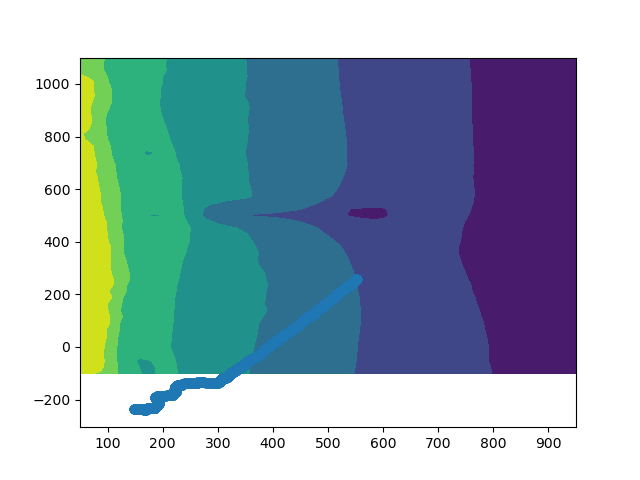

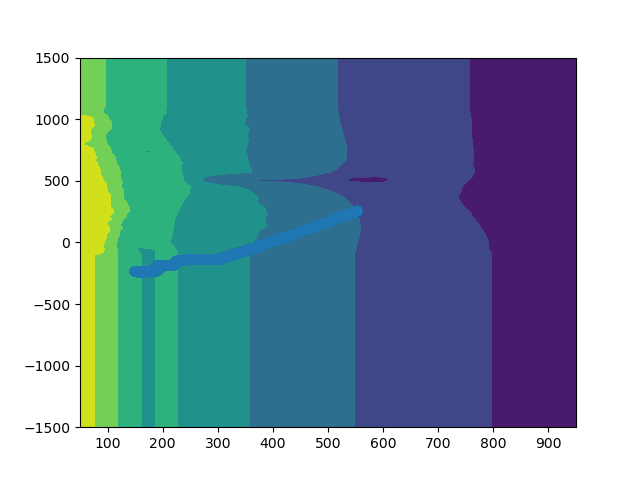

In [26]:
bathy_dataset = nc.Dataset('../data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
x_bathy = bathy_dataset['xFRF'][:]
y_bathy = bathy_dataset['yFRF'][:]
z_bathy = bathy_dataset['elevation'][0,:,:]

# Expand Bathymetry 
x_cgrid, y_cgrid = np.meshgrid(np.linspace(np.min(x_bathy), np.max(x_bathy), int((np.max(x_bathy)- np.min(x_bathy)))),
                               np.linspace(np.min(y_bathy), np.max(y_bathy), int((np.max(y_bathy)- np.min(y_bathy)))))

z_bathy_regridded = interpolate.interpn((x_bathy, y_bathy), np.transpose(z_bathy), (x_cgrid, y_cgrid), method='linear', fill_value=0)
x_bathy_expanded = np.linspace(50, 950, 900)
y_bathy_expanded = np.linspace(-1500, 1500, 3000)
x_cgrid_expand, y_cgrid_expand = np.meshgrid(x_bathy_expanded,
                                             y_bathy_expanded)
z_bathy_expanded = np.zeros(x_cgrid_expand.shape)
z_bathy_expanded[1400:2600, :] = z_bathy_regridded
for n in range(1400):
    z_bathy_expanded[n,:] = z_bathy_expanded[1400,:]

for n in range(y_bathy_expanded.size - 2600):
    z_bathy_expanded[n+2600,:] = z_bathy_expanded[2599,:]

fig, ax = plt.subplots()
ax.contourf(x_bathy, y_bathy, z_bathy)
ax.scatter(x_filtered, y_filtered)

fig, ax = plt.subplots()
ax.contourf(x_bathy_expanded, y_bathy_expanded, z_bathy_expanded)
ax.scatter(x_filtered, y_filtered)


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_92953/1695532312.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,10))


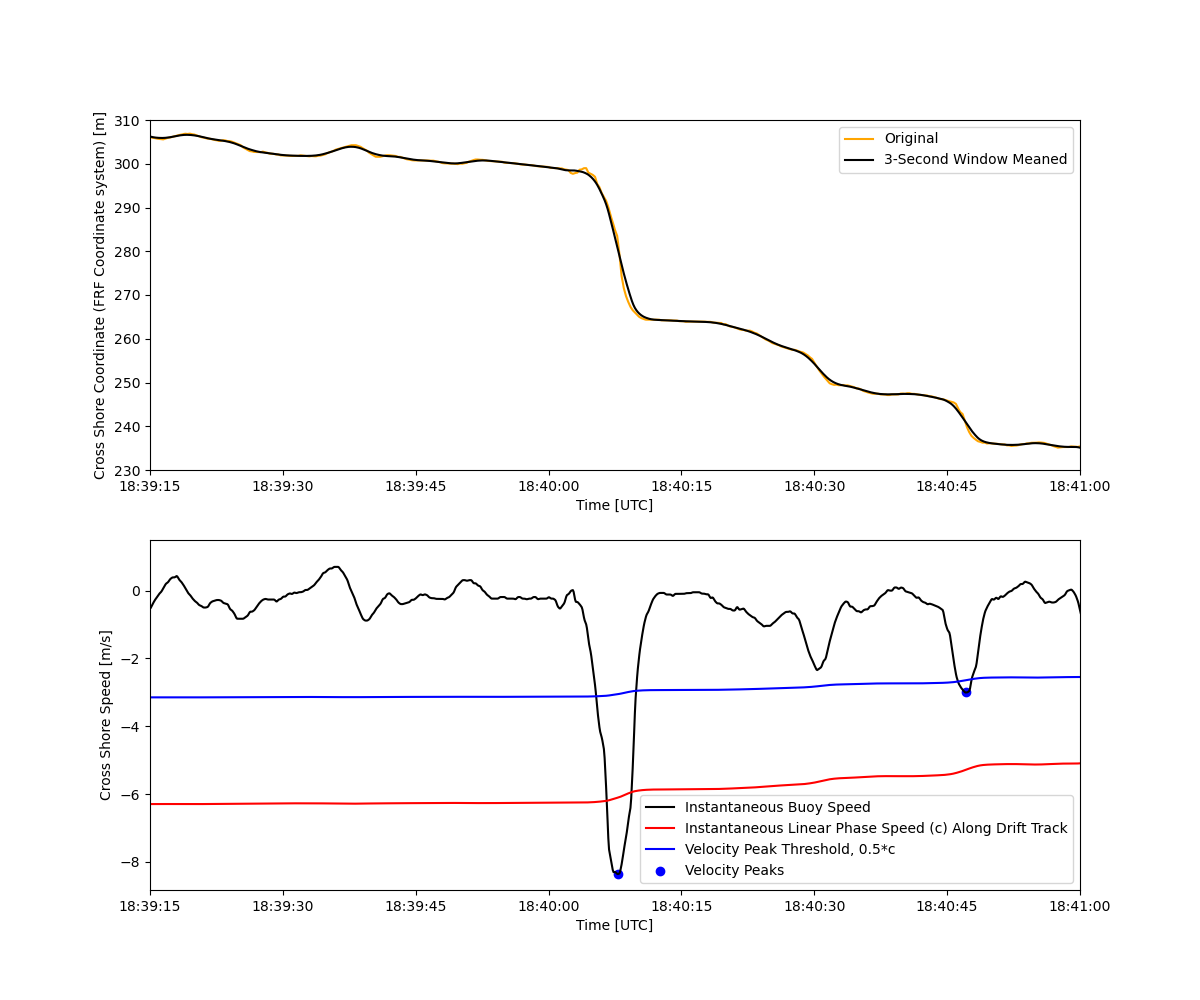

In [27]:


# Compute the Bathy along the buoy track
mission_df = pd.read_csv('../data/mission_df.csv').sort_values(by=['mission number'])
mission_num = 19
water_level = mission_df[mission_df['mission number'] == mission_num]['water level [m]'].values[0]
trajectory_bathy = bathy_along_track(bathy_file='../data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc', 
                                                    xFRF=x_filtered, 
                                                    yFRF=y_filtered,
                                                    single_trajectory=True)[0]
trajectory_depth = trajectory_bathy + water_level

# Compute Linear Phase Speed at each point in track
phase_speed_along_track = np.sqrt(np.abs(trajectory_depth * 9.8))

# Find the Peaks in the velocity
distance_between_peaks = int(3*(1/delta_t)) # 3 seconds between points
vel_threshold = 0.5 * phase_speed_along_track
peak_vel_indices = signal.find_peaks(-instantaneous_x_vel, height=vel_threshold, distance=distance_between_peaks)[0]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,10))
ax1.plot(time, x, color='orange', label='Original')
ax1.plot(time, x_filtered, color='k', label='3-Second Window Meaned')
ax1.set_xlabel('Time [UTC]')
ax1.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')
ax1.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))
ax1.set_ylim(230, 310)
ax1.legend()

# Instantaneous Velocity
ax2.plot(time, instantaneous_x_vel, color='k', label='Instantaneous Buoy Speed')
ax2.plot(time, -1 * phase_speed_along_track, color='r', label='Instantaneous Linear Phase Speed (c) Along Drift Track')
ax2.plot(time, -1 * 0.5*phase_speed_along_track, color='b', label='Velocity Peak Threshold, 0.5*c')
ax2.scatter(time[peak_vel_indices], instantaneous_x_vel[peak_vel_indices], color='b', label='Velocity Peaks')
ax2.set_xlabel('Time [UTC]')
ax2.set_ylabel('Cross Shore Speed [m/s]')
ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))
ax2.legend()



(230.0, 310.0)

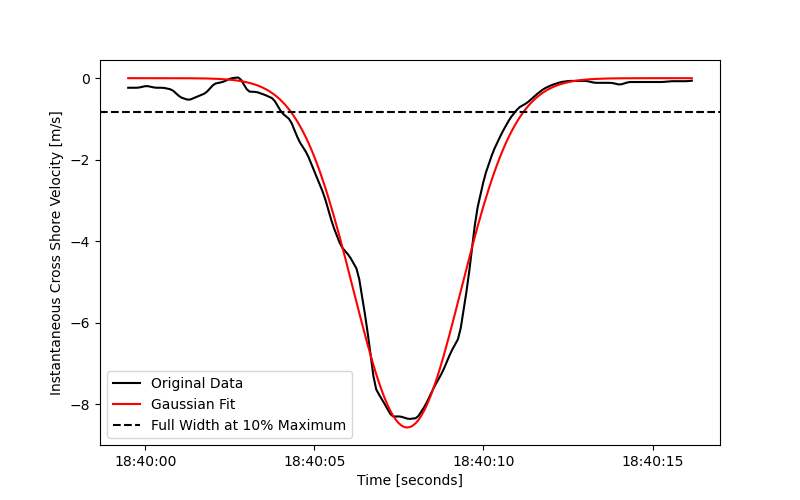

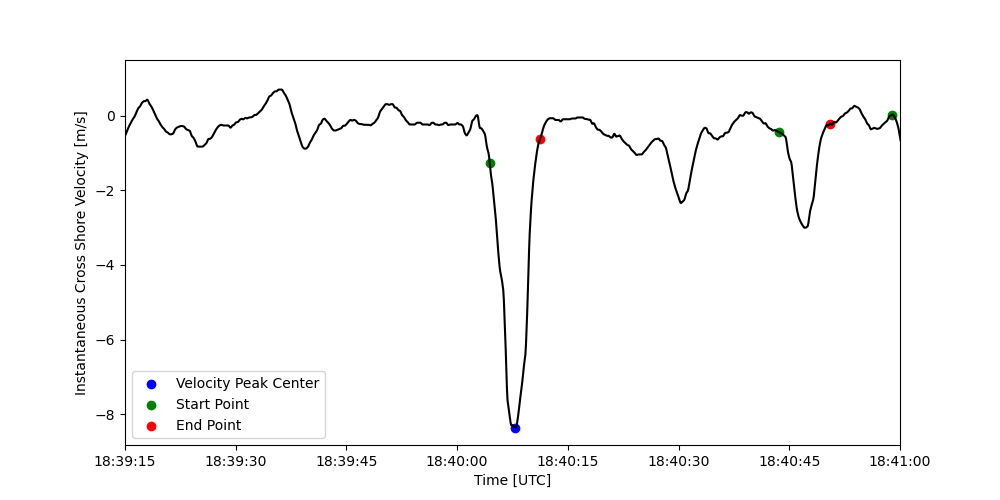

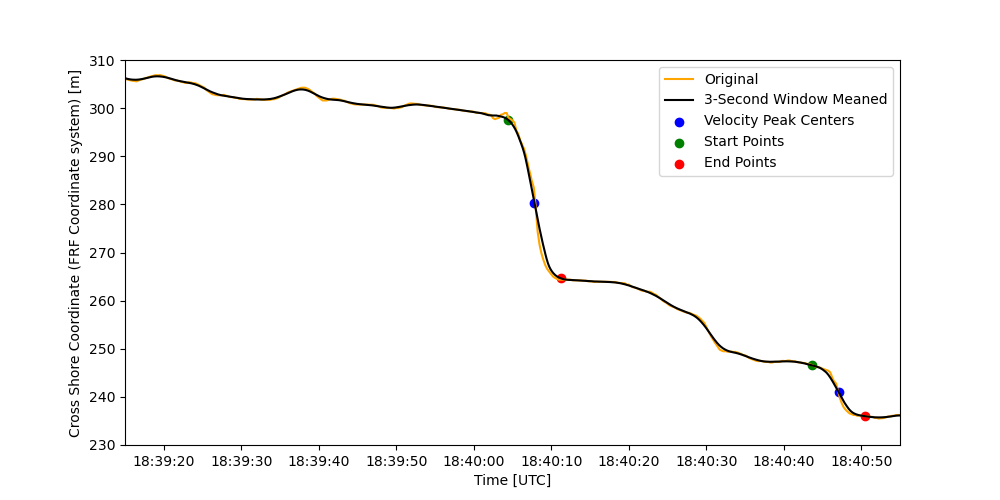

In [28]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def find_peak_width(signal, peak_index, window=10):
    """
    Compute the width of a peak in a signal by fitting a Gaussian function.

    Parameters:
    - signal: 1D array-like, the signal data.
    - peak_index: int, the index of the peak in the signal.
    - window: int, the number of points on each side of the peak to include in the fit.

    Returns:
    - width: float, the width of the peak defined as 4 standard deviations.
    """
    # Select the region around the peak
    x_data = np.arange(max(0, peak_index - window), min(len(signal), peak_index + window + 1))
    y_data = signal[max(0, peak_index - window):min(len(signal), peak_index + window + 1)]
    
    # Initial guess for the parameters
    initial_guess = [max(y_data), peak_index, 1.0]
    
    # Fit the Gaussian function to the data
    try:
        popt, _ = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
        amplitude, mean, stddev = popt
        # Compute the width as 4 standard deviations
        width = 4 * stddev
    except RuntimeError:
        # If the fitting fails, return None
        width = None
    
    return width

# Look at the data surrounding the peak index
# Select the region around the peak
n = 0
window = 100
peak_index = peak_vel_indices[n]
signal = -1 * instantaneous_x_vel # Flip the signal so the jumps are positive
delta_t = 1/12
x_data = np.arange(max(0, peak_index - window), min(len(signal), peak_index + window + 1))
y_data = signal[max(0, peak_index - window):min(len(signal), peak_index + window + 1)]

# Initial guess for the parameters
initial_guess = [max(y_data), peak_index, 1.0]

# Fit the Data in the window to a guassian function
popt, _ = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
amplitude, mean, stddev = popt
width = 4.3 * stddev # This is the "Full Width at Tenth of Maximum" (FWTM) value for a gaussian
jump_time = width * delta_t

start_point = (peak_vel_indices - width//2).astype(int)
end_point = (peak_vel_indices + width//2).astype(int)

# Plot the window of data and the optimized guassian
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(time[peak_index - window : peak_index + window + 1], -y_data, color='k', label='Original Data')
ax.plot(time[peak_index - window : peak_index + window + 1], -gaussian(x_data, amplitude, mean, stddev), color='r', label='Gaussian Fit')
ax.axhline(0.1 * instantaneous_x_vel[peak_index], color='k', linestyle='dashed', label='Full Width at 10% Maximum')
ax.legend()
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')

# Now lets look at the start and end points following this
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, instantaneous_x_vel, color='k')
ax.scatter(time[peak_vel_indices[0]], instantaneous_x_vel[peak_vel_indices[0]], color='b', label='Velocity Peak Center')
ax.scatter(time[start_point], instantaneous_x_vel[start_point], color='g', label='Start Point')
ax.scatter(time[end_point], instantaneous_x_vel[end_point], color='r', label='End Point')
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')
ax.legend()
# Good Examples
ax.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))

# Check the points on the distance curve
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, x, color='orange', label='Original')
ax.plot(time, x_filtered, color='k', label='3-Second Window Meaned')
ax.scatter(time[peak_vel_indices], x_filtered[peak_vel_indices], color='b', label='Velocity Peak Centers')
ax.scatter(time[start_point], x_filtered[start_point], color='g', label='Start Points')
ax.scatter(time[end_point], x_filtered[end_point], color='r', label='End Points')
ax.legend()
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')

# Good examples
ax.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 40, 55))
ax.set_ylim(230, 310)
